# whatsapp chat bot

Jenny Woods May 2020

Code to analyse my whatsapp chats (with my family) and make a rudimentary **jennybot**.

#### Import libraries

In [220]:
import os
import pandas as pd
import re
#import numpy as np
#from numpy.random import choice
#import pickle

import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
#nltk.download()
nltk.data.path = ['/home/jenny/sw/nltk_data']
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer(language='english')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

%matplotlib inline

#### Functions to read and write to pickle

In [151]:
def write_pkl(fname, obj):
    with open(fname,'wb') as pklf:
        pickle.dump((obj), pklf)
        print('Saved to', fname)
        
def read_pkl(fname):
    with open(fname,'rb') as pklf:
        obj = pickle.load(pklf)
    return obj

#### Function to read exported whatsapp chat

In [31]:
def read_chat(chatf) :
    
    # open chat textfile
    f = open(chatf, 'r')

    # loop over lines in file to extract date, time, sender and message
    dates, senders, messages = [],[],[]
    date, time, sender, message = None, None, None, None
    for line in f.readlines():
        
        try : # use regex to find date, time, sender, message expression
            (date, time, sender, message) = re.findall(r'(\d{2}/\d{2}/\d{4}), (\d{2}:\d{2}) - (.*?): (.*)', line)[0]
            dates.append(date+' '+time)
            senders.append(sender)
            messages.append(message)

        except : # some messages span several newlines!
            if messages:
                messages[-1] = messages[-1]+' '+line

    f.close()

    # store chat in dataframe
    df = pd.DataFrame(list(zip(dates, senders, messages)),
                      columns=['Date', 'Sender','Message'])

    df['Datetime'] = pd.to_datetime(df['Date'],format = '%d/%m/%Y %H:%M')
    df['Date'] = df['Datetime'].apply(lambda x : x.date())
    
    # reset index
    df.reset_index(drop=True, inplace=True)

    return df

### Read in whatsapp chats

Load all whatsapp chats in *datadir* (these are manually exported from whatsapp) and save messages after specified *start date* into a pandas dataframe.

In [37]:
datadir = './data/whatsapp/'
print('Data directory:', datadir)

startdate = pd.to_datetime('2019-01-01').date()
print('Start date:', startdate)

Data directory: ./data/whatsapp/
Start date: 2019-01-01


In [77]:
df = pd.DataFrame()
for chatf in os.listdir(datadir):
    
    # read full chat
    chat_df = read_chat(datadir + chatf)
    
    # append messages since start date to df
    df = df.append(chat_df[chat_df['Date'] > startdate])

# reset index
df.reset_index(drop=True, inplace=True)
print(len(df),'messages loaded')

14456 messages loaded


## Let's take a quick look at *all* the messages

#### Number of messages sent through time

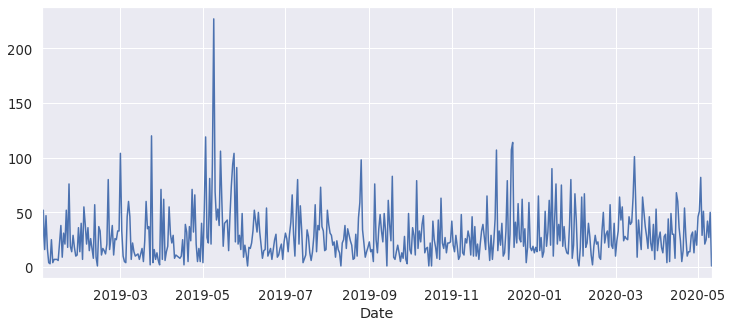

In [131]:
df.groupby(['Date']).count()['Message'].plot(figsize=(12,5))
plt.show()

Interestingly, the peak in May 2019 corresponds to telling my family I was getting married!

#### Number of messages sent by time of day

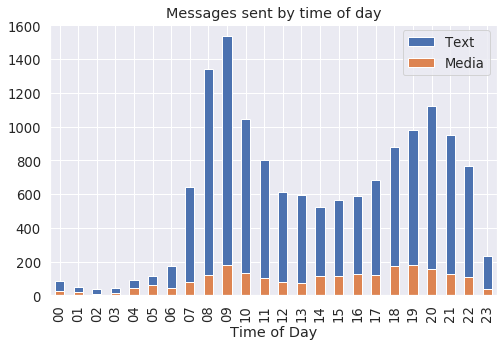

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# sum and plot number of messages per hour
ax = df['Datetime'].apply(lambda x : str(x.time())[0:2]).value_counts().sort_index().plot.bar(label='Text')

# overlay number of media messages in orange
ax = df[df['Message'] == '<Media omitted>']['Datetime'].apply(
    lambda x : str(x.time())[0:2]).value_counts().sort_index().plot.bar(color=sns.color_palette()[1],
                                                                        label='Media')

ax.set_xlabel('Time of Day')
ax.set_title('Messages sent by time of day')

ax.legend()

plt.show()

So, a bimodal distribution - correspondence typically in the morning or evening (asleep during the night, busy during the day)

#### Number of messages sent by sender

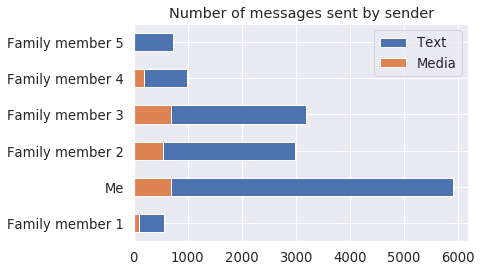

In [200]:
ax = df['Sender'].value_counts().sort_index()[2:].plot.barh(label='Text')

# overlay number of media messages in orange
ax = df[df['Message'] == '<Media omitted>']['Sender'].value_counts().sort_index()[2:].plot.barh(color=sns.color_palette()[1],
                                                                                   label='Media')

ax.set_yticklabels(['Family member 1','Me','Family member 2','Family member 3','Family member 4','Family member 5'])
ax.set_title('Number of messages sent by sender')
ax.legend()

plt.show()

Unsurprisingly I come out top sender (some group chats included, but mostly individual chats between me and each family member). 

## Message content

Focussing on messages sent by me only from here on.

In [180]:
mymsgs_df = df[df['Sender'] == 'Jenny Woods'].drop(columns='Sender')
mymsgs_df.reset_index(drop=True, inplace=True) # reset index

print(len(mymsgs_df),'messages sent by me')

5898 messages sent by me


#### Proportion of text vs. media messages

Identify media messages by *Media omitted* (chose to omit media when exporting the chats from whatsapp)

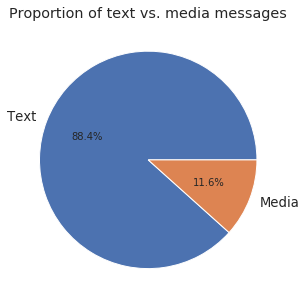

In [206]:
nmedia = len(mymsgs_df[mymsgs_df['Message'] == '<Media omitted>'])
ntext = len(mymsgs_df)-nmedia

pd.Series({'Text': ntext, 'Media': nmedia}).plot.pie(autopct='%1.1f%%',
                                                     label='',
                                                     title='Proportion of text vs. media messages',
                                                     figsize=(5,5))

plt.show()

Turns out quite a large proportion of the messages I send to my family are photos, videos or gifs!


#### Average message length

In [224]:
# Now let's drop those pesky <Media omitted> messages!
mymsgs_df = mymsgs_df[mymsgs_df['Message'] != '<Media omitted>']

# mean number of characters
avgchars = mymsgs_df['Message'].apply(lambda x: len(x)).mean()

# mean number of words
avgwords = mymsgs_df['Message'].apply(lambda x: len(x.split())).mean()

print('Avg. message length: %d words / %d characters' % (avgwords, avgchars))

Avg. message length: 7 words / 41 characters


### Let's take a look at my language

Use Natural Language Processing (NLP) to gain insights into the language used in my messages.

First concatenate all messages, remove symbols (with ascii encoding) and new lines, and make lowercase. Next use spaCy to tokenise, lemmatize (group different inflections of words), and remove punctuation, stopwords and web addresses.

In [233]:
# concatenate all messages
text = mymsgs_df['Message'].str.cat(sep = ' ')

# remove symbols, decode (remove b')
text = text.encode('ascii',errors='ignore').decode('UTF-8')
# make lowercase, remove newlines
text = text.lower().replace('\n',' ')

# remove web addresses
tokens = []
for token in text.split():
    if token[0:4] != 'http' and token[0:3] != 'www' and not re.search('androidappwhatsapp', token):
        tokens.append(token)
text = ' '.join(tokens)
        
# remove digits and various symbols
text = re.sub('[0-9_:;.,()@#%$~!?\+=><^`\*]+', '', text)
# replace forward slash, amphersand and plus
text = text.replace('/',' ').replace('&',' ').replace('&amp;', ' ')
    
doc = nlp(text)
tokens = []
for token in doc:
    if not token.is_punct | token.is_space : # ignore punctuation and spaces

        # Group together different inflections of a word (known as lemmatisation)
        if token.lemma_ != '-PRON-' :
            token = token.lemma_
        else :
            token = token.lower_

        lexeme = nlp.vocab[token]
        # ignore stopwords (words that add no meaning) and words less than 3 characters
        if lexeme.is_stop == False and len(token) > 2 :
            tokens.append(token)

#### Lexical diversity of my messages

(i.e. ratio of unique tokens to the total number of tokens)

In [234]:
print(float(len(set(tokens)))/float(len(tokens)))

0.23225806451612904


#### Word frequency distribution

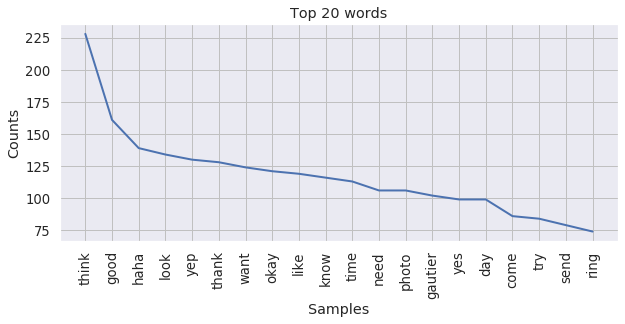

In [235]:
# concatonate words from all messages
tokens = pd.Series(tokens)

freq = nltk.FreqDist(tokens.values)
plt.figure(figsize=(10, 4))
freq.plot(20, cumulative=False, title='Top 20 words')
plt.show()

Words longer than 5 characters occuring more than 10 times

In [236]:
vocab = freq.keys()

freqwords = [(w,freq[w]) for w in vocab if len(w) > 8 and freq[w] > 10]
sorted(freqwords, key=lambda tup: tup[0])

[('apparently', 17),
 ('breakfast', 11),
 ('cambridge', 41),
 ('christmas', 22),
 ('definitely', 12),
 ('different', 18),
 ('excellent', 14),
 ('hopefully', 16),
 ('important', 12),
 ('interesting', 12),
 ('interview', 24),
 ('obviously', 23),
 ('yesterday', 17)]

## Creating a *jennybot*

Predicting my next word using a Markov chain.

From wikipedia:

*In probability theory, a Markov model is a stochastic model used to model randomly changing systems. It is assumed that future states depend only on the current state, not on the events that occurred before it (that is, it assumes the Markov property). A Markov chain is simply a type of Markov process that has either a discrete state space or a discrete index set.*

A 1-state Markov chain is used here - i.e. predication of the next word is based on the previous word only (an n-th order Markov model predicts the next work based on n previous words). Very rudimentary!

#### Clean the text

To prepare the message text for next word prediction, perform many of the same cleaning steps as above (remove digits, symbols, newlines, brackets, apostrophes etc), but do not lemmatize or remove stopwords - we want to make sentences!

In [242]:
def clean_messages_for_markov_model(text):
    
    # remove symbols, decode (remove b')
    text = text.encode('ascii',errors='ignore').decode('UTF-8')
    
    #remove digits, underscores, asterisks, colon/semi-colons, commas
    text = re.sub('[0-9_:;,\*]+', '', text)
    
    # remove apostrophes, brackets and various symbols
    text = text.replace("’","").replace("'","").replace('"','').replace(')','').replace('(','')
    text = re.sub(r'[%~@$#\-+=><^]','', text)
    
    # ignore web addresses (or at least those beginning http or www)
    filt=[]
    for word in text.split():
        if word[0:4] != 'http' and word[0:4] != 'www' :
            filt.append(word)
    text = ' '.join(filt)
    
    # replace forward slash with or
    text = text.replace('/',' or ').replace('&', ' and ')
    
    # remove newlines
    text = text.replace('\n',' ')
    # make lowercase
    text = text.lower()
   
    # remove spaces before punctuation, duplicate punctuation
    text = text.replace(' .', '.').replace(' ?','?').replace(' !','!')
    text = text.replace('!.','!').replace('?.','?').replace('. . ','. ')
    text = re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)
    
    return text

In [243]:
# concatenate all messages and clean/prepare for markov modelling
text_clean = clean_messages_for_markov_model(mymsgs_df['Message'].str.cat(sep = '. '))

# split into words
mc_words = [word for word in text_clean.split() if word != '.' and word != 'th' and word != 'st']

### Build Markov model

Construct matrix of *word - nextword* probabilites from the text

In [244]:
mc_df = pd.DataFrame(columns = ['word', 'nextword', 'freq'])

# assign words to 'word' column
mc_df['word'] = mc_words

# assign following/next words to 'nextword' column
nextwords = mc_words[1:]
nextwords.append('endoftext') # endoftext is just a filler since no word after last word
mc_df['nextword'] = nextwords

# find words at end of sentences - used to make sentence generation better!
end_words = []
for word in mc_words:
    if word[-1] in ['.','!','?'] and word != '.':
        end_words.append(word)

# assign freq column using groupby
mc_df['freq'] = mc_df.groupby(by = ['word','nextword'])['word','nextword'].transform('count').copy()

# remove duplicate rows and pivot dataframe to get matrix of all words and nextwords
mc_df = mc_df.drop_duplicates()
word_matrix = mc_df.pivot(index = 'word', columns= 'nextword', values='freq')
#word_matrix.head()

# to calc freq distribution, sum row frequencies and divide each element by the total
wordsum = word_matrix.sum(axis=1)
word_matrix = word_matrix.apply(lambda x: x/wordsum)

word_matrix.head()

nextword,a,a!,a.,a?,aaaaaahhhh.,aaaaahahhahaha.,aaaaand.,aaaand,aaaanyway.,aaahahaha,...,zeffs,zero,zimmer.,zip,zippo,zones,zoom.,zs?,zu,|
word,,,,,,,,,,,,,,,,,,,,,
a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001443,NaN,0.001443,NaN,NaN,NaN,NaN,NaN
a!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaaaaahhhh.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Function to generate sentences

In [245]:
def generate_sentence(firstword):
    
    word = firstword
    sentence = [word]
    
    while len(sentence) < 25:
        
        next_word = choice(a = list(word_matrix.columns),
                           p = (word_matrix.iloc[word_matrix.index == word].fillna(0).values)[0])

        if next_word == 'endoftext':
                continue
                
        elif next_word in end_words:
            if len(sentence) > 4:
                sentence.append(next_word)
                break
            else :
                sentence.append(next_word[:-1])
                continue
                
        else :
            sentence.append(next_word)
        
        word=next_word
        
    sentence = ' '.join(sentence)
    
    return sentence

### Finally, generate some (nonsense) jennybot sentences...

In [312]:
generate_sentence('i')

'i bought it sounds like the morning to make one of red wine making a surprise plant based sounds like that?'

In [315]:
generate_sentence('gautier')

'gautier thinks about bikes for something?'

In [333]:
generate_sentence('haha')

'haha no photos of me french equivalent would like it.'

In [346]:
generate_sentence('we')

'we homemade twister coloured paper notes in touch before the brexit freedom of some heavy lifting.'